[1] Package import

In [10]:
import os


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wooseungjin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wooseungjin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[2] functions   

In [11]:
#activation function
#sigmoid function
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)


[3] read data

In [12]:
review_data = load_files(r"movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

trainX,testX,trainY, testY = train_test_split(X, y, test_size=0.3, shuffle=False)

trainX,testX,trainY, testY = trainX.T,testX.T,trainY.T, testY.T
    
#Datanum
trDataNum=1401
tDataNum=601


[4] initailize values

In [13]:
# Epoch num
NUM_EPOCH=30000

#Array for writing loss, accuracy
trLossArray=np.zeros((NUM_EPOCH+1,1))
tLossArray=np.zeros((NUM_EPOCH+1,1))
trAcArray=np.zeros((NUM_EPOCH+1,1))
tAcArray=np.zeros((NUM_EPOCH+1,1))

lr=0.05#learning Rate

#weight

# np.random.seed(0)

layer_num = 3

u=np.random.randn(150,1500)#layer 1 weight (input : input feature) 

v=np.random.randn(15,150)#layer 2 weight (input: w1 output feature) 

w=np.random.randn(1,15)#layer 3  weight (input :w2 output feature) 

#bias 
a=np.zeros((1,1))#layer 1  bias 

b=np.zeros((1,1))#layer 2 bias 

c=np.zeros((1,1))#layer 3 bias 

#X for drawing the graph
x_=np.arange(NUM_EPOCH+1)#X

#ramda
ramda = 0.001

[5] training(gradient decent)

In [14]:
for epoch in range(NUM_EPOCH+1):
    
    #forward propagation(train)
    trZ1=np.dot(u,trainX)+a#Layer 1
    trA1=sigmoid(trZ1)

    trZ2=np.dot(v,trA1)+b#Layer 2
    trA2=sigmoid(trZ2)
    
    trZ3=np.dot(w,trA2)+c#Layer 3
    trA3=sigmoid(trZ3)

    #get train loss
    trloss=-(np.multiply(trainY,np.log(trA3))+np.multiply((1-trainY),np.log(1-trA3)))
    trloss=1/trDataNum*np.sum(trloss) + ramda/(2*layer_num)*(np.power(u,2).sum() + np.power(v,2).sum() + np.power(w,2).sum())
    trLossArray[epoch]=trloss
    
    #forward propagation(test)
    tZ1=np.dot(u,testX)+a#Layer 1
    tA1=sigmoid(tZ1)
    
    tZ2=np.dot(v,tA1)+b#Layer 2
    tA2=sigmoid(tZ2)
    
    tZ3=np.dot(w,tA2)+c#Layer 3
    tA3=sigmoid(tZ3)
    
    #get test loss
    tloss=-(np.multiply(testY,np.log(tA3))+np.multiply((1-testY),np.log(1-tA3)))
    tloss=1/tDataNum*np.sum(tloss) + ramda/(2*layer_num)*(np.power(u,2).sum() + np.power(v,2).sum() + np.power(w,2).sum())
    tLossArray[epoch]=tloss
    
    #get Accuracy
    trainPY=np.where(trA3>=0.5,1.,0.)
    trAccuracy=((trainPY == trainY).sum())/trDataNum
    trAcArray[epoch]=trAccuracy
    
    testPY=np.where(tA3>=0.5,1.,0.)
    tAccuracy=((testPY == testY).sum())/tDataNum
    tAcArray[epoch]=tAccuracy
    
    #backward propagation
    dz3=trA3-trainY
    dw=1/trDataNum*np.dot(dz3,trA2.T)
    dc=1/trDataNum*np.sum(dz3,axis=1,keepdims=True)
    
    dz2=np.multiply(np.dot(w.T,dz3),trA2*(1.0-trA2))
    dv=1/trDataNum*np.dot(dz2,trA1.T)
    db=1/trDataNum*np.sum(dz2,axis=1,keepdims=True)
    
    dz1=np.multiply(np.dot(v.T,dz2),trA1*(1.0-trA1))
    du=1/trDataNum*np.dot(dz1,trainX.T)
    da=1/trDataNum*np.sum(dz1,axis=1,keepdims=True)
    
    
    #update weight and bias
    u=(1-ramda*lr)*u-lr*du
    a=(1-ramda*lr)*a-lr*da    

    v=(1-ramda*lr)*v-lr*dv
    b=(1-ramda*lr)*b-lr*db
    
    w=(1-ramda*lr)*w-lr*dw
    c=(1-ramda*lr)*c-lr*dc
    
    
    #check the data per epoch 500
    if epoch%500==0:    
        print("epoch :" + str(epoch+1))
        print("train loss :  " +np.array2string(trloss))
        print("test loss :  " +np.array2string(tloss))
        print("train accuracy :  " +np.array2string(trAccuracy))
        print("test accuracy :  " +np.array2string(tAccuracy))


epoch :1
train loss :  39.6062259
test loss :  39.58987242
train accuracy :  0.49892934
test accuracy :  0.50249584
epoch :501
train loss :  36.56023002
test loss :  36.57036898
train accuracy :  0.5503212
test accuracy :  0.54242928
epoch :1001
train loss :  34.7948564
test loss :  34.8118691
train accuracy :  0.5710207
test accuracy :  0.53244592
epoch :1501
train loss :  33.12086982
test loss :  33.14391164
train accuracy :  0.59100642
test accuracy :  0.53078203
epoch :2001
train loss :  31.52796159
test loss :  31.55739997
train accuracy :  0.60742327
test accuracy :  0.55574043
epoch :2501
train loss :  30.01079098
test loss :  30.04711164
train accuracy :  0.63169165
test accuracy :  0.56572379
epoch :3001
train loss :  28.56540594
test loss :  28.6088568
train accuracy :  0.64882227
test accuracy :  0.57737105
epoch :3501
train loss :  27.18834811
test loss :  27.23900221
train accuracy :  0.67023555
test accuracy :  0.59900166
epoch :4001
train loss :  25.87615303
test loss : 

[6] find correct and wrong 10 images

[7] Plot the loss curve

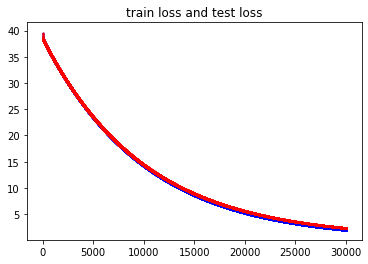

In [15]:
plt.title("train loss and test loss")
plt.scatter(x_,trLossArray ,c="b",s=1)#train loss 
plt.scatter(x_,tLossArray ,c="r",s=1)#test loss
plt.show()

[8] Plot the accuracy curve

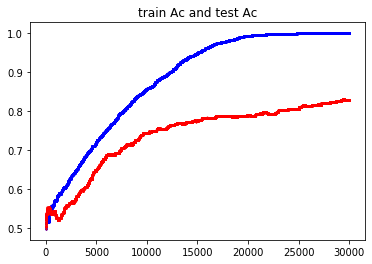

In [16]:
plt.title("train Ac and test Ac")
plt.scatter(x_,trAcArray,c="b",s=1)#train ac 
plt.scatter(x_,tAcArray,c="r",s=1)#test ac 
plt.show()

[9] Plot the accuracy value

In [17]:
print("Final train accuracy :  " +np.array2string(trAcArray[NUM_EPOCH]))
print("Final test accuracy :  " +np.array2string(tAcArray[NUM_EPOCH]))

Final train accuracy :  [1.]
Final test accuracy :  [0.82861897]


[10] Plot the classification example

[11] Plot testing accuracy

In [ ]:
print("Final test accuracy :  " +np.array2string(tAcArray[NUM_EPOCH]))